# Hands-on VASP and Phonopy: calculate vibrations!
## Introduction 

Welcome to this tutorial on the use of VASP and Phonopy to calculate phonon modes.

It will guide you through two examples: a $\mathsf{Si}$ crystal and a $\mathsf{BaTiO_{3-x}H_x}$ crystal.<br>

The tutorial uses a Python interface to write and read inputs/output files from VASP, called Atomic Simulation Environment (ASE) (https://wiki.fysik.dtu.dk/ase/index.html).
While the inputs files are created using ASE and the following python scripts in this notebook, VASP is executed on the ILL  high-performance computing (HPC) server (or cluster) called `masterp`.
You will also learn how to submit jobs to this cluster.

If not already done, please copy this Jupyer file (.ipynb) to your home directory.

Let us load all the useful Python modules. Execute the following cell by selecting it and clicking the $ \blacktriangleright $ symbol in the toolbar.

In [99]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import bulk
from ase.visualize import view
from ase.calculators.vasp import Vasp
from ase.io import read, write
from phonopy import Phonopy, load
from phonopy.structure.atoms import PhonopyAtoms
from phonopy.interface.calculator import read_crystal_structure
from phonopy.interface.vasp import parse_set_of_forces, write_vasp
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
%env VASP_PP_PATH=.

env: VASP_PP_PATH=.


Define two functions creating the bash files required to submit jobs to the cluster.

In [87]:
# Function writing a VASP job script called ILL_hpc_vasp_job_local.sh #

def write_job(directory, #The directory to write the file
              label,     #The job name
              nodes,     #The number of requested nodes
              queue):    #The name of the requested queue in the cluster
    f = open(directory+'/ILL_hpc_vasp_job_local.sh', "w")
    f.write("""#!/bin/bash

#PBS -q """+queue+"""
#PBS -N """+label+"""
#PBS -l nodes="""+nodes+""":ppn="""+queue[-2:]+"""
# if nodes > 1 : FOR THE q.2015_16 queue activate one of the following lines:
#export I_MPI_DEVICE="rdma:ofa-v2-ib0" 
#export I_MPI_DEVICE="rdssm:ofa-v2-ib0"

module load intel/14.0.1
module load intelmpi/4.1.0.024
module load vasp/intelmpi/5.4.1

cd $PBS_O_WORKDIR
ulimit -s unlimited
mpirun vasp_std > vasp_job.log\n""")
    
    f.close()
    

# Function writing a VASP job script dedicated to the calculation of Hellman-Feynman Forces (HFF). 
# It launches a VASP run at the Gamma-point only for an array of displacements generated using Phonopy 

def write_job_HFF(directory,#The directory to write the file  
                  label,    #The job name
                  Nimg,     #The number of displacement 
                  nodes,    #The number of requested nodes
                  queue):   #The name of the requested queue in the cluster
    f = open(directory+'/ILL_hpc_vasp_job_local.sh', "w")
    f.write("""#!/bin/bash

#PBS -q """+queue+"""
#PBS -N """+label+"""
#PBS -l nodes="""+nodes+""":ppn="""+queue[-2:]+"""
# if nodes > 1 : FOR THE q.2015_16 queue activate one of the following lines:
#export I_MPI_DEVICE="rdma:ofa-v2-ib0" 
#export I_MPI_DEVICE="rdssm:ofa-v2-ib0"

module load intel/14.0.1
module load intelmpi/4.1.0.024
module load vasp/intelmpi/5.4.1

cd $PBS_O_WORKDIR
ulimit -s unlimited

for i in {001.."""+f'{Nimg:03d}'+"""}
do
cp POSCAR-$i POSCAR

mpirun vasp_std > vasp_job.log

wait

cp vasprun.xml vasprun-$i.xml
rm POSCAR OUTCAR

done

#End of script (make sure line before this gets run)""")
    
    f.close()

#Function writing the displacement as a series of POSCAR files to be read by VASP.

def write_supercells_with_displacements(
    supercell, cells_with_displacements, directory, pre_filename="POSCAR", width=3
):
    ids = np.arange(len(cells_with_displacements), dtype=int) + 1
    write_vasp(directory+"S%s" % pre_filename, supercell, direct=True)
    for i, cell in zip(ids, cells_with_displacements):
        filename = directory+"{pre_filename}-{0:0{width}}".format(
            i, pre_filename=pre_filename, width=width
        )
        write_vasp(filename, cell, direct=True)

## Example 1: Si crystal

In this tutorial, we will create a model of silicon crystal, display it and perform simple geometry optimization and phonon calculations using VASP and Phonopy.

ASE allows us to quickly generate structures - both molecular and periodic.

Here, we just tell ASE to create a silicon lattice for us.

### 1. Preparing the structure

In [ ]:
si_conventional = bulk('Si', 'fcc', a=5.43, cubic=True)
si_primitive = bulk('Si', 'fcc', a=5.43)

We can visualize the cell using one of several tools which come with ASE

In [ ]:
view(si_conventional, viewer='x3d')

In [ ]:
si_conventional.cell

In [ ]:
view(si_primitive, viewer='x3d')

In [ ]:
si_primitive.cell

A more sophisticated optional viewing engine is NGLView.

In [ ]:
try:
    import nglview
except ImportError:
    !pip install nglview
    import nglview
view(si_primitive, viewer='ngl')

### 2. Relaxing the structure (geometry optimization)

Phonon calculations need to be performed on a fully optimized structure, i.e. forces on atoms should be as close to zero as possible. Geometry optimization determines location of atoms in a crystal (or in a molecule) at 0K. The accuracy of the relaxation needs to be high in order to obtain reliable phonon frequencies.

Here, we will use ASE to construct the VASP input files for relaxation. First, create a directory where job files will be kept. This will help in maintaining clean project space between runs.

In [ ]:
relaxation_dir='relaxation_si/'

In order to properly define the VASP job, we need to pass a number of parameters describing how we want to run the calculation.

The keyword `PREC` tells VASP how to set default values for various convergence parameters (energy, FFT grid, etc.). Setting this parameter to `Accurate` means VASP is going to help achieving accurate forces and then more accurate phonon spectrum.

The kinetic energy cutoff specifies the energy cutoff for the plane-wave basis set in eV. Here, we will use `200` eV.

The SCF loop will be considered converged, if the difference between current and previous energy will be less than `EDIFF` eV. Here, we choose 5.0e-7 eV per atom.

We also want to achieve convergence for atomic forces - they should be less than 1e-5 eV/A. The negative sign of `EDIFFG` parameter means that the relaxation is stopped when the norms of all the forces are smaller than |ediffg|, which is a more convenient setting.

We will use the standard `PBE` functional, well suited for first order properties like geometries.

Specifying `IBRION` and `ISIF` lets us tweak the relaxation algorithm - we want to perform a relaxation calculation (`IBRION!=0`) and vary atomic positions and cell volume at each step.

For the k-point grid, we want to use a large number of points in all directions. Hence, we chose `8,8,8`. The grid should be centered on the Γ-point.

Lastly, we should not store very large, unneeded files after the job completes, so we need to tell VASP to delete those.


In [ ]:
calc=Vasp(
    directory=relaxation_dir,      
    label='Si_relaxation',
    # Convergence parameters
    prec='Accurate',# Vasp precision tag
    encut=500,      # energy cutoff for the plane-wave basis set in eV
    ediff=5e-7,     # Relax electronic structure until 5e-7 eV energy change between 2 electronic loop
    ediffg=-1e-5,   # Relax ionic forces below 1e-5 eV/A
    # Job settings
    xc="pbe",       # Use the PBE exchange and correlation functional
    ibrion=1,       # Ionic relaxation
    isif=2,         # Relax positions and cell volume
    # K-point grid settings
    kpts=[8,8,8],   # Kpoint grid
    gamma=True,     # Gamma-centered grid
    # Output settings
    lwave=False,    # Do not save wave fuction files (large files)
)

In [ ]:
calc.write_input(si_primitive)

Now you can examine the content of `relaxation_si` subdirectory.

In [ ]:
import glob
print("\n".join(glob.glob("relaxation_si/*")))

The four files with names in capital letters are VASP input files.

`INCAR` lists parameters used in the energy and force calculations.
`KPOINTS` describes the kpoint grid used.
`POSCAR` describes the unit cell, atom types and their positions.
`POTCAR` contains pseudopotentials for each atomic species.

All four files are required for the calculation we are about to run.


Now it is time to run the VASP calculation. For this, we need to submit the job to the cluster:<br>

a) Connect to the cluster login node: open a terminal and log in with: `$ ssh <your_username>@masterp.ill.fr`.<br>

b) Check that the queue you want to submit to has nodes availables using the `qload` command. If no nodes are available, change the queue in the submit script `vasp.sh`.

c) Copy your job directory `relaxation_si` to the cluster. From the VISA instance, use `scp -r relaxation_si <your_username>@masterp.ill.fr:` to transfer the whole directory to the main cluster node.

d) Launch the job. From the job directory on the cluster launch the job using `$ qsub vasp.sh`. You can then monitor your job with `$ qstat`.

e) Check the VASP log file. Type: `$ more vasp_job.log`. It is updated during the calculation. You can see each electronic and ionic step.

f) The calculation shoud take aprrox. 2 mins on 1x8 cpus (there is only 1 atom to be displaced). Once it is completed, you will see in the log file `reached required accuracy - stopping structural energy minimisation`. Copy back the job folder to your home directory using `$ cp -r /destination_directory_on_the_cluster ~/your_username/your_directory/`.

- Have a look at the results! The main output file of VASP is called `OUTCAR`. You can have a look and check out the forces decreasing with increasing ionic steps. The same data is also outputed in a xml file `vasprun.xml`. Use `read()` to load the file and plot the force along the ionic steps.

## Example 2: $\mathsf{BaTiO_{3-x}H_x}$ crystal

Barium titanate oxyde-hydride ($\mathsf{BaTiO_{3-x}H_x}$) is a mixed-anion material displaying hydride-ion ($\mathsf{H^-}$) conductivity (see https://doi.org/10.1038/nmat3302). The mobility of $\mathsf{H^-}$ may be exploited for applications such as in energy storage and conversion devices, and in catalyst technologies for hydrogenation reactions. The virational modes of the crystal structure of $\mathsf{BaTiO_{3-x}H_x}$ are of great interest for this research because they relate to the local coordianation environement around $\mathsf{H^-}$. Specifically, they indicate the presence of oxygen vacancies neighbouring the $\mathsf{H^-}$ anions, which may serve as jumping sites for $\mathsf{H^-}$ and enable the ionic conductivity (see https://doi.org/10.1039/c9ta11912d).

<img src=btoh.png width="600"/>

In this example, we simulate the vibrational density of states (vDOS) spectrum and the phonon band structure of a stoichiometric $\mathsf{BaTiO_{3-x}H_x}$, free of vacanices.

### 1. Preparing the structure

**1.0** - Find on the web a Crystallographic Information File (.cif) for a simple **cubic** $\mathsf{BaTiO_{3}}$ crystal.

**1.1** - Open your .cif file in the software VESTA and edit it in order to replace one oxygen atom by a hydrogen atom. Export it as a vasp file and rename it as 'POSCAR' (without extension). This file will be read by VASP as the input structure.

- Now, load the POSCAR file into ASE using `read()`:

In [41]:
atoms=read('POSCAR')

You can vizualie the loaded structure to check it using `view()`

In [42]:
view(atoms)

<Popen: returncode: None args: ['/nethome/ds/finel/.conda/envs/MDANSE_school...>

### 2. Relaxing the structure

Before calculating the phonon mode of our crystal structure, the forces and the cell volume need to be 'relaxed', that is, the total force on each atom and the total stress on the cell need to approach 0. This can be done with VASP, using a minimization algorithm (see https://www.vasp.at/wiki/index.php/Category:Ionic_minimization). This algorithm will update the atomic positions as well as the lattice constants until the forces vanish.

- Create a new directory dedicated to the structure relaxation, it will contain the VASP input/output files for the relaxation.

In [97]:
relaxation_dir='lucas_relaxation/'

- Use the function `Vasp()` in ASE to generate the input files. Here, we propose a set of very coarse settings to speed up the calculation. Have a look at which settings one should modify to increase the accuracy on the forces.

In [50]:
calc=Vasp(
    directory=relaxation_dir,      
    label='BaTiO3-xHx_relaxation',
    encut=500,    #energy cutoff for the plane-wave basis set in eV
    xc="pbe",     #Use the PBE exchange and correlation functional
    ediff=1e-7,   #Relax electronic structure until 1e-5 eV energy change between 2 electronic loop
    ibrion=1,     #Ionic relaxation
    isif=3,       #Relax positions, cell shape, cell volume 
    ediffg=-1e-4, #Relax ionic forces below 1e-3 eV/A
    nsw=300,      #Max 300 ionic steps
    kpts=[5,5,5], #Kpoint grid
    gamma=True,   #Gamma-centered grid
    lwave=False,  #Do not save wave fuction files (large files)
    prec='Accurate',#Vasp precision tag
)

- Write out the input files using `write_input` and create a job bash script using `write_job()`.


In [51]:
calc.write_input(atoms)
write_job(directory=relaxation_dir,label='BaTiO3-xHx_relaxation',nodes='1',queue='q.2010_08')

- Submit your job to the cluster:<br>

a) Connect to the cluster login node: open a terminal and log in with: `$ ssh your_username@masterp.ill.fr`.<br>

b) Check that the queue you want to submit to has nodes availables using the `qload` command. If no nodes are available, change the queue in the above cell and execute it again.

c) Copy your job directory to the cluster. Your VISA home folder is mounted on the cluster login node, and it is called as your username. However, the compute nodes haven't access to your home folder, so **you must copy your job directory to the cluster**. From the cluster login node, use `$ cp -r ~/your_username/your_directory/ /destination_directory_on_the_cluster`.<br>

d) Launch the job. From the job directory on the cluster (you can move to your job directory using `$ cp /destination_directory_on_the_cluster`) launch the job using `$ qsub ILL_hpc_vasp_job_local.sh`. You can then monitor your job with `$ qstat`.

e) Check the VASP log file. Type: `$ more vasp_job.log`. It is updated during the calculation. You can see each electronic and ionic step.

f) The calculation shoud take aprrox. 1 min on 1x8 cpus. Once it is completed, you will see in the log file `reached required accuracy - stopping structural energy minimisation`. Copy back the job folder to your home directory using `$ cp -r /destination_directory_on_the_cluster ~/your_username/your_directory/`.

- Have a look at the results! The main output file of VASP is called `OUTCAR`. You can have a look and check out the forces decreasing with increasing ionic steps. The same data is also outputed in a xml file `vasprun.xml`. Use `read()` to load the file and plot the force along the ionic steps.

/nethome/ds/finel/.conda/envs/MDANSE_school/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


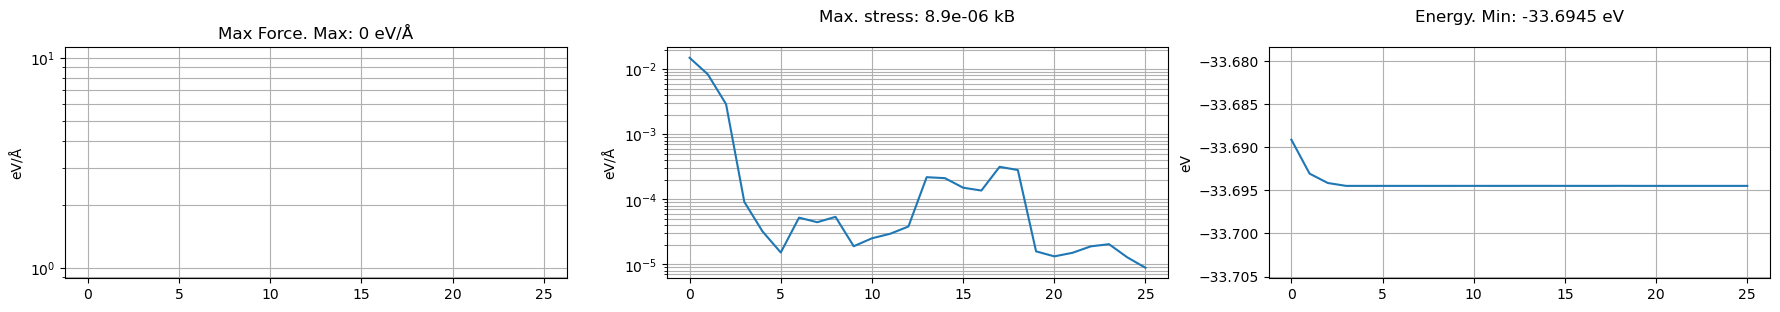

In [82]:
vasp_results=read(relaxation_dir+'/vasprun.xml',index=':', format='vasp-xml')   #Load the results
E=np.array([img.get_potential_energy() for img in vasp_results])                         #Extract the total energy for each ionic step
maxF=np.array([np.max(np.linalg.norm(img.get_forces(),axis=1)) for img in vasp_results]) #Extract the maximum force for each ioninc step
maxS=np.array([np.max(np.linalg.norm(img.get_stress(),axis=0)) for img in vasp_results]) #Extract the maximum stress for each ioninc step

fig, ax=plt.subplots(1,3,figsize=(22,3))                                                 #Plot them
ax[0].grid(which='both')
ax[0].set_title('Max Force. Max: {:0.2g} eV/Å'.format(maxF[-1]))
ax[0].set_ylabel('eV/Å')
ax[0].set_yscale('log')
ax[2].grid(which='both')
ax[2].set_title('Energy. Min: {:0.4f} eV\n'.format(E[-1]))
ax[2].set_ylabel('eV')
ax[2].set_ylim(ymin=E[-1]-2*(E[0]-E[-1]),ymax=E[0]+2*(E[0]-E[-1]))
ax[1].grid(which='both')
ax[1].set_title('Max. stress: {:0.2g} kB\n'.format(maxS[-1]))
ax[1].set_ylabel('eV/Å')
ax[1].set_yscale('log')

ax[0].plot(maxF)
ax[1].plot(maxS)
ax[2].plot(E);

**2.0** - Why the maximum force is exactly 0? What was actually relaxed in this calculation?

### 3. Calculating phonons

Now that the forces in the structure are close to zero, we can finally calculate its phonon modes. In this tutorial we use a **finite displacements approach** (or direct approach) implemented in the package Phonopy. You can remind yourself about the concept of lattice dynamics and phonons with this document: https://www.neutron-sciences.org/articles/sfn/pdf/2011/01/sfn201112007.pdf and read about the finite displacement approach here: https://www.neutron-sciences.org/articles/sfn/pdf/2011/01/sfn201112008.pdf.
Finally, you can have  look at how it is implemented in Phonopy here: https://phonopy.github.io/phonopy/formulation.html.

The finite displacements approach constists of slightly displacing each atom of the unit cell from their equilibrium position, and perform a single-point DFT calculation for each displacement in order to compute the resulting forces, called Hellmann-Feynman forces (HFF). Using the HFF, the force constants of the structures are computed and provide the phonon modes (the eigenfrequencies and the eigenvectors). 
- Phonopy can propose a minimum number of displacements based on the symetry operation of the unitcell. Use the following cell to generate the displacement.

In [83]:
# Create the atomic displacement using Phonopy and write them out as POSCAR files #
atoms=read(relaxation_dir+"/CONTCAR") #read relaxed cell
unitcell, optional_structure_info = read_crystal_structure(relaxation_dir+"/CONTCAR", interface_mode='vasp') #read the relaxed cell
phonon = Phonopy(unitcell, supercell_matrix=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]) #build a 2x2x2 supercell to perform the DFT calculations
phonon.generate_displacements(distance=0.03) #generate displacements of 0.03 A around the equilibrium positions
supercells = phonon.supercells_with_displacements 

**3.1**  Why do we use a supercell instead of the unitcell for this phonon calculation?
-  Create a new directory, dedicated to your phonon calculation, and write the displacements files.

In [98]:
phonon_dir='lucas_phonon/'
write_supercells_with_displacements(supercell=phonon.supercell, cells_with_displacements=supercells,directory=phonon_dir)

**3.2** - How many displacements were generated?

**3.3** - Let's setup VASP for the single-point calculations. What keywords did we change compared to the relaxation job?

In [96]:
#Setup VASP for an energy and forces calculation#
calc=Vasp(
    directory=phonon_dir,      
    label='BaTiO3-xHx_phonon',
    encut=500,    #energy cutoff for the plane-wave basis set in eV
    xc="pbe",     #Use the PBE exchange and correlation functional
    ediff=1e-7,   #Relax electronic structure until 1e-7 eV energy change between 2 electronic loop
    ibrion=-1,    #No ionic relaxation
    kpts=[3,3,3], #Kpoint grid
    gamma=True,   #Gamma-point centered
    lwave=True,  #Do not save wave fuction files (large files)
    prec='Normal',#Vasp precision tag
)
#Write the VASP job script#
write_job_HFF(Nimg=len(phonon.displacements),directory=phonon_dir,label='BaTiO3-xHx_phonon_small_cell',nodes='1',queue='q.2015_16')
calc.write_input(atoms)

- Check out the new job script. And submit it using the same procedure as before. If the 2015_16 queue is fully occupied, you can also submit to the 2014.16 or the 2020.32 queue.

**3.4** - While the calculation is running (it should take ~20 mins on 1x16 cores), have a look to this publication https://doi.org/10.1039/c9ta11912d. Find out how was performed the calculations (which unitcell and supercell, what VASP and phonopy settings). Do you expect different results in your calculation?
**To save some time you can also copy the results from the directory "3-Calculating phonon" to your phonon directory. Only the vasprun.xml files are needed.**

- Once the calculation is finished, copy back your phonon calculation directory to your home folder. Then, let's use again Phonopy to parse the results using `parse_set_of_forces()` and compute the force constants using `phonon.produce_force_constants()`.

In [91]:
vasp_results=parse_set_of_forces(num_atoms=phonon.dataset['natom'], forces_filenames=[phonon_dir+'/vasprun-'+'{:03.0f}'.format(i)+'.xml' for i in np.arange(1,len(phonon.displacements)+1)], use_expat=True, verbose=True)
phonon.forces=vasp_results['forces']
phonon.produce_force_constants()

counter (file index): 1 2 3 4 


- Calculate the vDOS using Phonopy. Here, we use `run_projected_dos()` to separate the contribution from each species.

In [92]:
phonon.run_mesh([15, 15, 15], with_eigenvectors=True, is_mesh_symmetry=False)
phonon.run_projected_dos(#sigma=0.05,
                         freq_min=None,
                         freq_max=None,
                         freq_pitch=0.05,
                         use_tetrahedron_method=True,
                         direction=None,
                         xyz_projection=False,
    )
vdos=phonon.get_projected_dos_dict()

- Plot the results

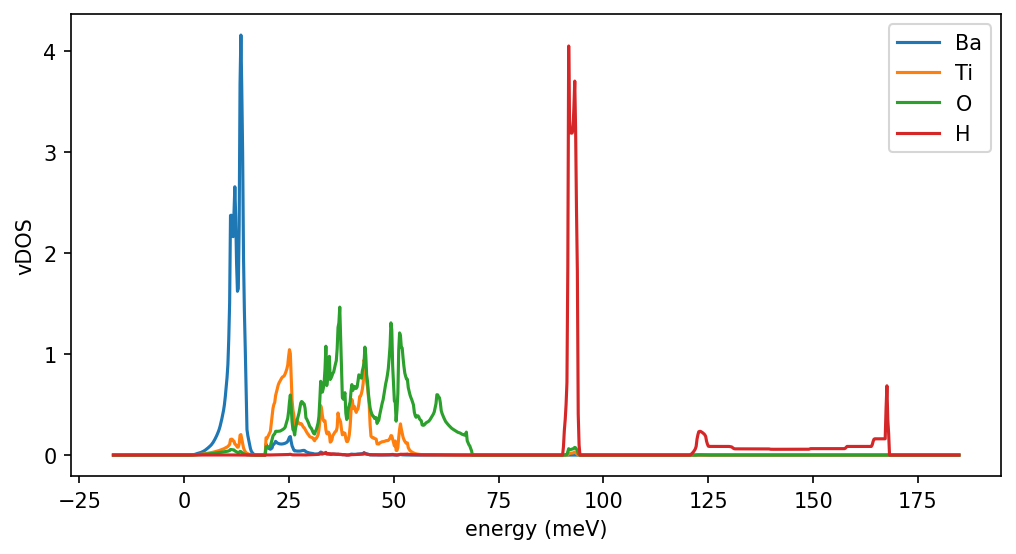

In [93]:
%matplotlib inline
Ba_indices=np.where(np.array(phonon.unitcell.symbols)=='Ba')[0]
Ti_indices=np.where(np.array(phonon.unitcell.symbols)=='Ti')[0]
O_indices=np.where(np.array(phonon.unitcell.symbols)=='O')[0]
H_indices=np.where(np.array(phonon.unitcell.symbols)=='H')[0]

figvdos, ax=plt.subplots(1,1,figsize=(8,4),dpi=150)
ax.plot(vdos['frequency_points']*4.136, np.sum(vdos['projected_dos'][Ba_indices,:],axis=0),label='Ba')
ax.plot(vdos['frequency_points']*4.136, np.sum(vdos['projected_dos'][Ti_indices,:],axis=0),label='Ti')
ax.plot(vdos['frequency_points']*4.136, np.sum(vdos['projected_dos'][O_indices,:],axis=0),label='O')
ax.plot(vdos['frequency_points']*4.136, np.sum(vdos['projected_dos'][H_indices,:],axis=0),label='H')

ax.set_ylabel('vDOS')
ax.set_xlabel('energy (meV)')
ax.legend();

**3.4** - Why H is the highest vibrational frequencies and Ba the lowest ?

**3.5** - Compare this calcualted vDOS with the INS spectra from this publication: https://doi.org/10.1039/c9ta11912d. What matches well and what are the differences (in frequencies and intensity)? How would you explain the differences?

Finally, let's calculate the phonon band structure. It requires to calculate the eigenvecotrs and eigenfrequencies at specific q-points along a defnined path. This path usually follow high-symmetry points of the Brilloin zone of the crystal. Here, we use the cubic Brilloin zone.

- The following cell defines the path and a the phonon calculation along this path.

In [94]:
path = [[[0, 0, 0], [0, 0.5, 0], [0.5, 0.5, 0],[0.5, 0.5, 0.5], [0, 0, 0]]]  #High-symmetry points in the cubic Brillouin zone.
path_labels = ["$\\Gamma$", "X", "M","R", "$\\Gamma$"]                       #Names of the high-symmetry points in the cubic Brillouin zone.
qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)
phonon.run_band_structure(qpoints, path_connections=connections, labels=path_labels, with_eigenvectors=True)
bs=phonon.get_band_structure_dict()
phonon.write_yaml_band_structure(filename=phonon_dir+'/bandstructure.yaml') #write the bandstructure file to vizualise it later

- And plot the bandstructure!

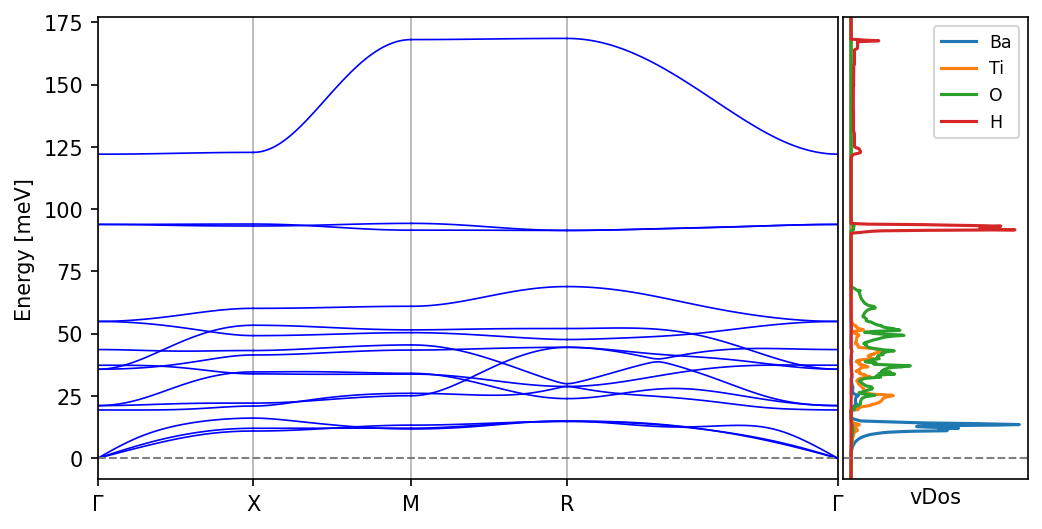

In [95]:
figbs, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]},figsize=(8,4),dpi=150)
for i, distance in enumerate(bs['distances']):
    for freq in bs['frequencies'][i].T:
        ax[0].plot(distance,freq*4.136,'b-',lw=0.8)
ax[0].set_ylabel('Energy [meV]')
ax[0].set_xlim(left=0, right=bs['distances'][-1][-1])
ax[0].set_xticks(np.unique(np.array(bs['distances'])[:,0::50]))
ax[0].set_xticklabels(path_labels)
ax[0].grid(True, axis='x')
ax[0].axhline(0,0,1,ls='dashed', color='grey', lw=1)

ax[1].plot(np.sum(vdos['projected_dos'][Ba_indices,:],axis=0),vdos['frequency_points']*4.136,label='Ba')
ax[1].plot(np.sum(vdos['projected_dos'][Ti_indices,:],axis=0),vdos['frequency_points']*4.136,label='Ti')
ax[1].plot(np.sum(vdos['projected_dos'][O_indices,:],axis=0),vdos['frequency_points']*4.136,label='O')
ax[1].plot(np.sum(vdos['projected_dos'][H_indices,:],axis=0),vdos['frequency_points']*4.136,label='H')

ax[1].set_xlabel('vDos')
ax[1].set_ylim(ax[0].get_ybound())
ax[1].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft=False)      # ticks along the bottom edge are off
ax[1].axhline(0,0,1,ls='dashed', color='grey', lw=1)
ax[1].legend(loc='best',fontsize='small')
ax[1].set_xticks([])
figbs.subplots_adjust(wspace=0.01)

**3.7** - Can you identify the acoustic and the optic modes in the band structure?

**3.8** - Vizualize the vibrations! Open https://henriquemiranda.github.io/phononwebsite/phonon.html and load the file `bandstructure.yaml` located in your phonon calculation directory.

**3.9** - The lowest H frequencies are relatively independent of q while the highest frequencies show a strong q-dependence. What is the physical meaning of these features?